<html>
<h3>The main purpose of this is to estimate the revenue.</h3>

The procedure is
<ul>
<li> 
    Multiply the averaged nightly price with the average number of reviews, which we do it in two ways:
    <ul>
    <li> 1. estimate this for every month, because of the time varying signal shown in check-time-varying-trend-and-nan.ipynb. This also involves imputing the monthly price table. I used KNN and the best n_neighbors is decided in check-impute-month-price.ipynb</li>
    <li> 2. use yearly estimated value </li>
    </ul>
    The 1st method is preferred, as the 2nd method means imputing the NaN in review counts as 1, which may overestimate the revenue.
</li>
<li> 
    Inflate this number with the estimated portion of guests that leave review (50-75%), average length of stays (3-4 nights) and the tax/fee that taken out from airbnb host. There numbers can be found on 
    <a href=http://insideairbnb.com/data-assumptions>Inside Airbnb</a>, 
    <a href=https://commissions.sfplanning.org/cpcpackets/2014-001033PCA.pdf>SF planning report</a>,
    travel booking/info site like
    <a href=https://www.momondo.com/hotels/seattle>this</a>,
    <a href=https://travellemming.com/seattle-travel-tips/#:~:text=3%2D4%20days%20is%20a,one%20day%20in%20Seattle%20itinerary.>this</a>, and
    <a href=https://www.kayak.com/Seattle-Hotels.7054.hotel.ksp#:~:text=The%20cheapest%203%2Dstar%20hotel,in%20Seattle%20for%203%20days.>this</a>
</li>
</ul>
For plotting, I downloaded a zip boundary json file from <a href=https://github.com/OpenDataDE/State-zip-code-GeoJSON/tree/master>here</a>, and simply use matplotlib patch to plot the polygons. See ZipPlotter class in this notebook for details.
</html>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import json
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

### 1. prepare the data frames

In [2]:
listings = pd.read_csv('seattle_airbnb_data.dir/listings.csv')
reviews = pd.read_csv('seattle_airbnb_data.dir/reviews.csv')
calendar = pd.read_csv('seattle_airbnb_data.dir/calendar.csv')

In [3]:
def filter_and_combine():
    condition_1 = (listings.room_type == 'Entire home/apt')
    condition_2 = (listings.property_type.isin(['House','Apartment','Townhouse','Condominium','Loft']))
    condition_3 = listings.first_review.apply(lambda x: int(x.split('-')[0])<=2015 if isinstance(x,str) else False)
    condition_4 = listings.last_review.apply(lambda x: int(x.split('-')[0])>=2015 if isinstance(x,str) else False)
    condition_5 = (listings.bedrooms <= 4)
    listings_filtered = listings.loc[ condition_1 & condition_2 & condition_3 & condition_4 & condition_5, 
                                     ['id','zipcode','bedrooms','first_review','last_review','reviews_per_month']].copy()
    
    # filtered the calendar so it has the same listing_id
    calendar_filtered = calendar[calendar.available == 't'].copy()                                  
    calendar_filtered['price'] = calendar_filtered['price'].str.lstrip('\$').replace('\,','',regex=True).astype(float)
    calendar_filtered['month'] = calendar_filtered.date.apply(lambda x: x.split('-')[1])
                                     
    month_price = calendar_filtered.groupby(['listing_id','month']).agg({'price':'mean'}).unstack(level=1)
    month_price.columns = month_price.columns.get_level_values(1)
    month_price = pd.merge(left = listings_filtered[['id']],
                           right = month_price,
                           left_on = 'id',
                           right_on = 'listing_id',
                           how = 'left')
    month_price.set_index('id', inplace=True)
    
    # add the average price to listings
    avg_price = calendar_filtered.groupby(['listing_id']).agg({'price':'mean'})
    avg_price.columns = ['avg_price']
    listings_filtered = pd.merge(left = listings_filtered,
                                 right = avg_price,
                                 left_on = 'id',
                                 right_on = 'listing_id',
                                 how = 'left')
    
    # deal with review
    reviews['yr'] = reviews.date.apply(lambda x:x.split('-')[0])
    reviews['month'] = reviews.date.apply(lambda x:x.split('-')[1])
    reviews_filtered = reviews[reviews.yr=='2015'].copy()
    review_counts = reviews_filtered.groupby(['listing_id','month']).agg({'id':'count'}).unstack(level=1)
    review_counts.columns = review_counts.columns.get_level_values(1)
    review_counts = pd.merge(left = listings_filtered[['id']],
                             right = review_counts,
                             left_on = 'id',
                             right_on = 'listing_id',
                             how = 'left')
    review_counts.set_index('id', inplace=True)
    
    # update the first review, last review in the listings
    first_last_review = reviews_filtered.groupby(['listing_id']).agg({'date':['min','max']})
    first_last_review.columns = ['first_review_2015', 'last_review_2015']
    listings_filtered = pd.merge(left = listings_filtered,
                                 right = first_last_review,
                                 left_on = 'id',
                                 right_on = 'listing_id',
                                 how = 'left')
    
    # get the avg reviews per month on listings
    listings_filtered['total_reviews'] = review_counts.sum(axis=1).values
    listings_filtered['delta_days'] = pd.to_datetime(listings_filtered.last_review_2015) \
                                        - pd.to_datetime(listings_filtered.first_review_2015)
    listings_filtered['delta_days'] = listings_filtered['delta_days'].apply(lambda x: x.days)
    listings_filtered['reviews_per_month_2015'] = (listings_filtered['total_reviews'] - 1) / listings_filtered['delta_days'] * 30
    idx = (listings_filtered['delta_days'] <= 30)
    listings_filtered.loc[idx, 'reviews_per_month_2015'] = listings_filtered.loc[idx, 'total_reviews']
    
    return listings_filtered, month_price, review_counts

In [4]:
listings_filtered, month_price, review_counts = filter_and_combine()

In [5]:
listings_filtered

,id,zipcode,bedrooms,first_review,last_review,reviews_per_month,avg_price,first_review_2015,last_review_2015,total_reviews,delta_days,reviews_per_month_2015
0,241032,98119,1.0,2011-11-01,2016-01-02,4.07,85.000000,2015-01-03,2015-12-24,68.0,355,5.661972
1,953595,98119,1.0,2013-08-19,2015-12-29,1.48,170.931271,2015-02-15,2015-12-29,34.0,317,3.123028
2,278830,98119,3.0,2012-07-10,2015-10-24,0.89,462.739726,2015-01-04,2015-10-24,16.0,293,1.535836
3,2493658,98119,1.0,2014-04-27,2015-12-20,1.55,167.947531,2015-01-02,2015-12-20,20.0,352,1.619318
4,175576,98119,1.0,2011-07-21,2015-11-25,3.33,94.803922,2015-04-20,2015-11-25,48.0,219,6.438356
...,...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,98103,2.0,2015-10-01,2015-12-27,1.56,191.651982,2015-10-01,2015-12-27,5.0,87,1.379310
1994,8578490,98103,1.0,2015-10-01,2015-10-16,0.63,67.782805,2015-10-01,2015-10-16,2.0,15,2.000000
1995,3383329,98107,1.0,2014-07-08,2015-12-29,4.01,102.818815,2015-01-03,2015-12-29,54.0,360,4.416667
1996,8101950,98107,3.0,2015-09-27,2015-09-27,0.30,359.000000,2015-09-27,2015-09-27,1.0,0,1.000000


Text(0, 0.5, 'reviews per month in 2015')

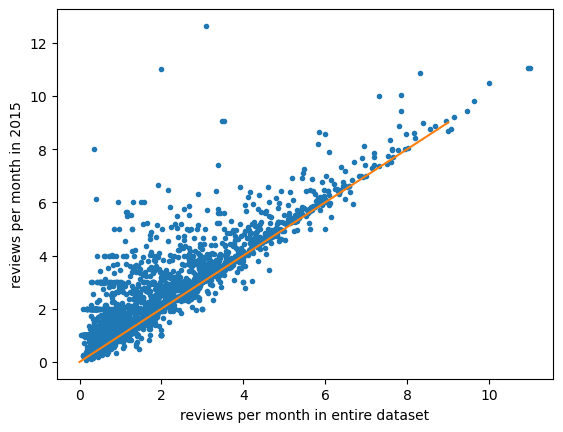

In [6]:
plt.plot(listings_filtered.reviews_per_month, listings_filtered.reviews_per_month_2015, '.')
xtmp = np.arange(0, 10); ytmp = xtmp; plt.plot(xtmp, ytmp, '-')
plt.xlabel('reviews per month in entire dataset')
plt.ylabel('reviews per month in 2015')

### somewhat surprising that the two are actually comparable, with 2015 only slightly better

### 2. first method is to impute the monthly price, fillna(0) in the review counts, then multiply them

In [7]:
month_price_imputed = pd.DataFrame(KNNImputer(n_neighbors=10).fit_transform(month_price),
                                   columns = month_price.columns, index = month_price.index)
month_price_imputed

,01,02,03,04,05,06,07,08,09,10,11,12
id,,,,,,,,,,,,
241032,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.00000,85.000000,85.000000,85.000000
953595,164.266667,149.604674,154.000000,154.566667,169.645161,193.600000,197.193548,192.935484,170.60000,141.645161,128.400000,192.387097
278830,516.666667,465.517241,456.451613,458.333333,456.451613,456.666667,458.064516,456.451613,457.50000,457.258065,456.666667,458.064516
2493658,198.625000,127.200000,142.935484,154.566667,169.645161,193.600000,197.193548,192.935484,170.60000,141.645161,128.400000,192.387097
175576,93.550000,93.854052,92.887097,95.000000,94.600000,92.777778,95.000000,95.000000,94.95000,95.000000,95.000000,95.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
262764,184.090909,183.965517,184.032258,185.000000,195.000000,195.000000,195.000000,203.774194,211.00000,190.319355,187.666667,190.125806
8578490,57.500000,55.000000,68.000000,71.096667,81.666667,106.538462,65.000000,65.000000,65.00000,65.000000,65.000000,65.000000
3383329,95.000000,95.000000,101.000000,107.454545,108.777778,113.333333,110.172414,111.260870,104.62963,95.000000,95.000000,95.000000


In [8]:
review_counts

,01,02,03,04,05,06,07,08,09,10,11,12
id,,,,,,,,,,,,
241032,4.0,8.0,7.0,4.0,7.0,8.0,6.0,4.0,7.0,1.0,7.0,5.0
953595,NaN,1.0,5.0,6.0,3.0,5.0,NaN,4.0,6.0,2.0,1.0,1.0
278830,1.0,1.0,NaN,1.0,3.0,3.0,4.0,NaN,1.0,2.0,NaN,NaN
2493658,1.0,NaN,NaN,NaN,NaN,1.0,NaN,4.0,4.0,4.0,4.0,2.0
175576,NaN,NaN,NaN,3.0,5.0,10.0,8.0,6.0,7.0,4.0,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
262764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0
8578490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
3383329,5.0,2.0,6.0,2.0,4.0,4.0,5.0,7.0,5.0,8.0,4.0,2.0


In [9]:
(review_counts.fillna(0) * month_price_imputed).sum(axis=1) / 12

id
241032     481.666667
953595     476.946626
278830     615.345523
2493658    275.943481
175576     377.952315
              ...    
262764      78.841487
8578490     10.833333
3383329    463.099153
8101950     31.229167
8902327     15.639785
Length: 1998, dtype: float64

In [10]:
listings_filtered['monthly_proxy_revenue_method_1'] = (review_counts.fillna(0) * month_price_imputed).sum(axis=1).values / 12

In [11]:
listings_filtered

,id,zipcode,bedrooms,first_review,last_review,reviews_per_month,avg_price,first_review_2015,last_review_2015,total_reviews,delta_days,reviews_per_month_2015,monthly_proxy_revenue_method_1
0,241032,98119,1.0,2011-11-01,2016-01-02,4.07,85.000000,2015-01-03,2015-12-24,68.0,355,5.661972,481.666667
1,953595,98119,1.0,2013-08-19,2015-12-29,1.48,170.931271,2015-02-15,2015-12-29,34.0,317,3.123028,476.946626
2,278830,98119,3.0,2012-07-10,2015-10-24,0.89,462.739726,2015-01-04,2015-10-24,16.0,293,1.535836,615.345523
3,2493658,98119,1.0,2014-04-27,2015-12-20,1.55,167.947531,2015-01-02,2015-12-20,20.0,352,1.619318,275.943481
4,175576,98119,1.0,2011-07-21,2015-11-25,3.33,94.803922,2015-04-20,2015-11-25,48.0,219,6.438356,377.952315
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,98103,2.0,2015-10-01,2015-12-27,1.56,191.651982,2015-10-01,2015-12-27,5.0,87,1.379310,78.841487
1994,8578490,98103,1.0,2015-10-01,2015-10-16,0.63,67.782805,2015-10-01,2015-10-16,2.0,15,2.000000,10.833333
1995,3383329,98107,1.0,2014-07-08,2015-12-29,4.01,102.818815,2015-01-03,2015-12-29,54.0,360,4.416667,463.099153
1996,8101950,98107,3.0,2015-09-27,2015-09-27,0.30,359.000000,2015-09-27,2015-09-27,1.0,0,1.000000,31.229167


### 3. second method is simply avg_price*reviews_per_month

In [12]:
listings_filtered['monthly_proxy_revenue_method_2'] = listings_filtered['avg_price'] * listings_filtered['reviews_per_month']

In [13]:
listings_filtered

,id,zipcode,bedrooms,first_review,last_review,reviews_per_month,avg_price,first_review_2015,last_review_2015,total_reviews,delta_days,reviews_per_month_2015,monthly_proxy_revenue_method_1,monthly_proxy_revenue_method_2
0,241032,98119,1.0,2011-11-01,2016-01-02,4.07,85.000000,2015-01-03,2015-12-24,68.0,355,5.661972,481.666667,345.950000
1,953595,98119,1.0,2013-08-19,2015-12-29,1.48,170.931271,2015-02-15,2015-12-29,34.0,317,3.123028,476.946626,252.978282
2,278830,98119,3.0,2012-07-10,2015-10-24,0.89,462.739726,2015-01-04,2015-10-24,16.0,293,1.535836,615.345523,411.838356
3,2493658,98119,1.0,2014-04-27,2015-12-20,1.55,167.947531,2015-01-02,2015-12-20,20.0,352,1.619318,275.943481,260.318673
4,175576,98119,1.0,2011-07-21,2015-11-25,3.33,94.803922,2015-04-20,2015-11-25,48.0,219,6.438356,377.952315,315.697059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,98103,2.0,2015-10-01,2015-12-27,1.56,191.651982,2015-10-01,2015-12-27,5.0,87,1.379310,78.841487,298.977093
1994,8578490,98103,1.0,2015-10-01,2015-10-16,0.63,67.782805,2015-10-01,2015-10-16,2.0,15,2.000000,10.833333,42.703167
1995,3383329,98107,1.0,2014-07-08,2015-12-29,4.01,102.818815,2015-01-03,2015-12-29,54.0,360,4.416667,463.099153,412.303449
1996,8101950,98107,3.0,2015-09-27,2015-09-27,0.30,359.000000,2015-09-27,2015-09-27,1.0,0,1.000000,31.229167,107.700000


Text(0, 0.5, 'method 2')

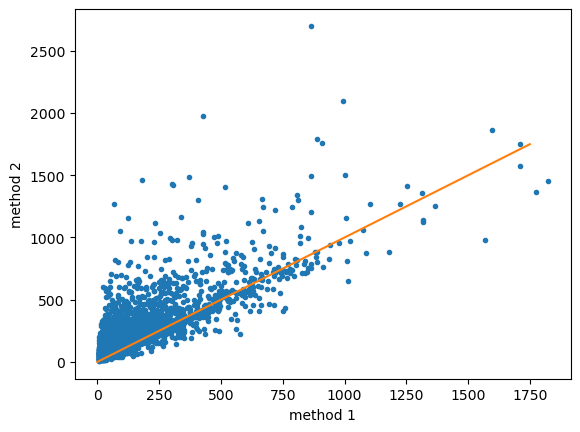

In [14]:
plt.plot(listings_filtered.monthly_proxy_revenue_method_1, listings_filtered.monthly_proxy_revenue_method_2, '.')
xtmp = np.arange(0,1750); ytmp = xtmp; plt.plot(xtmp, ytmp, '-')
plt.xlabel('method 1'); plt.ylabel('method 2')

### method 2 is somewhat higher, especially when the revenue is small; this is as expected, because essentially it fills nan with mean, instead of zero as in method 1.

### 4. now make some plots to see if we are better off doing airbnb or not; let's stick with method 1 for now to be more conservative

In [15]:
listings_filtered['monthly_profit_low_end'] = listings_filtered['monthly_proxy_revenue_method_1'] * 3 / 0.75 * 0.3
listings_filtered['monthly_profit_high_end'] = listings_filtered['monthly_proxy_revenue_method_1'] * 4 / 0.5 * 0.2

In [16]:
rent_ref = pd.read_csv('rent_ref.csv')
rent_ref.set_index('zip_code', inplace=True)
rent_ref = rent_ref.iloc[:,-5:]
rent_ref.columns = [0.0, 1.0, 2.0, 3.0, 4.0]
rent_ref = rent_ref.stack().reset_index()
rent_ref.columns = ['zipcode', 'bedrooms', 'rent']
rent_ref['zipcode'] = rent_ref['zipcode'].astype(str)
rent_ref

,zipcode,bedrooms,rent
0,98119,0.0,1108.800
1,98119,1.0,1247.400
2,98119,2.0,1334.025
3,98119,3.0,1663.200
4,98119,4.0,2205.000
...,...,...,...
130,98125,0.0,982.800
131,98125,1.0,1108.800
132,98125,2.0,1190.700
133,98125,3.0,1483.650


In [17]:
listings_filtered = pd.merge(left=listings_filtered,
                             right=rent_ref,
                             left_on=['zipcode', 'bedrooms'], right_on=['zipcode','bedrooms'],
                             how = 'left')

In [18]:
listings_filtered['better_airbnb_high_end'] = (listings_filtered['monthly_profit_high_end'] > listings_filtered['rent'])
listings_filtered['better_airbnb_low_end'] = (listings_filtered['monthly_profit_low_end'] > listings_filtered['rent'])
listings_filtered 

,id,zipcode,bedrooms,first_review,last_review,reviews_per_month,avg_price,first_review_2015,last_review_2015,total_reviews,delta_days,reviews_per_month_2015,monthly_proxy_revenue_method_1,monthly_proxy_revenue_method_2,monthly_profit_low_end,monthly_profit_high_end,rent,better_airbnb_high_end,better_airbnb_low_end
0,241032,98119,1.0,2011-11-01,2016-01-02,4.07,85.000000,2015-01-03,2015-12-24,68.0,355,5.661972,481.666667,345.950000,578.000000,770.666667,1247.40,False,False
1,953595,98119,1.0,2013-08-19,2015-12-29,1.48,170.931271,2015-02-15,2015-12-29,34.0,317,3.123028,476.946626,252.978282,572.335951,763.114602,1247.40,False,False
2,278830,98119,3.0,2012-07-10,2015-10-24,0.89,462.739726,2015-01-04,2015-10-24,16.0,293,1.535836,615.345523,411.838356,738.414627,984.552836,1663.20,False,False
3,2493658,98119,1.0,2014-04-27,2015-12-20,1.55,167.947531,2015-01-02,2015-12-20,20.0,352,1.619318,275.943481,260.318673,331.132177,441.509570,1247.40,False,False
4,175576,98119,1.0,2011-07-21,2015-11-25,3.33,94.803922,2015-04-20,2015-11-25,48.0,219,6.438356,377.952315,315.697059,453.542778,604.723704,1247.40,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,98103,2.0,2015-10-01,2015-12-27,1.56,191.651982,2015-10-01,2015-12-27,5.0,87,1.379310,78.841487,298.977093,94.609785,126.146380,1389.15,False,False
1994,8578490,98103,1.0,2015-10-01,2015-10-16,0.63,67.782805,2015-10-01,2015-10-16,2.0,15,2.000000,10.833333,42.703167,13.000000,17.333333,1297.80,False,False
1995,3383329,98107,1.0,2014-07-08,2015-12-29,4.01,102.818815,2015-01-03,2015-12-29,54.0,360,4.416667,463.099153,412.303449,555.718984,740.958645,1297.80,False,False
1996,8101950,98107,3.0,2015-09-27,2015-09-27,0.30,359.000000,2015-09-27,2015-09-27,1.0,0,1.000000,31.229167,107.700000,37.475000,49.966667,1738.80,False,False


In [19]:
class ZipPlotter():
    def __init__(self, json_file):
        self.boundaries = {}
        with open(json_file, 'r') as fid:
            dat = json.load(fid)
        for feature in dat['features']:
            zip_code = feature['properties']['ZCTA5CE10']
            self.arr = []
            self._helper(feature['geometry']['coordinates'])
            self.boundaries[zip_code] = self.arr.copy()

    def _helper(self, head):
        ''' helper for dfs to unpack the json_file '''
        if isinstance(head[0][0], float):
            self.arr.append(np.array(head))
            return
        for leaf in head:
            self._helper(leaf)
 
    def plot(self, val_dict, label='some values', vmin=None, vmax=None,
             figsize=(10,5), xlim=(-122.5,-122.2), ylim=[47.5,47.8]):
        ''' val_dict = {zip_code: val} '''
        cmap = cm.get_cmap('viridis', 8)        
        if vmin is None:
            vmin = min(val_dict.values())
        if vmax is None:
            vmax = max(val_dict.values())
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

        fig = plt.figure(figsize=(4,4))
        ax = plt.gca()
        for k, v in val_dict.items():
            print(k, v)
            for polygon in self.boundaries[k]:
                ax.add_patch(Polygon(polygon, fc=cmap(norm(v)), ec='white', closed=True))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=label)
        return fig

In [20]:
zp = ZipPlotter('./seattle_airbnb_data.dir/wa_washington_zip_codes_geo.min.json')

98101 1276.7055
98102 1254.871387283237
98103 1417.4688118811882
98104 986.9343749999999
98105 1290.9342233009709
98106 1245.2416666666668
98107 1432.470618556701
98108 1221.7875000000001
98109 1445.8632352941177
98112 1469.928409090909
98115 1516.4138888888888
98116 1485.2055555555553
98117 1432.6890410958904
98118 1217.403409090909
98119 1338.1617469879518
98121 1450.818870967742
98122 1247.4985807860262
98125 1200.5777777777778
98126 1351.223275862069
98133 1262.7794117647059
98136 1420.875
98144 1142.9117088607595
98177 1686.125
98199 1595.4399999999998


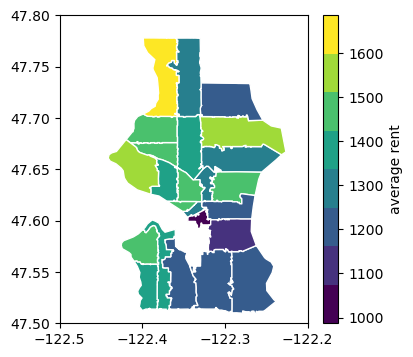

In [21]:
tmp = listings_filtered.groupby('zipcode').agg({'rent':'mean', 'id':'count'})
tmp.columns = ['rent', 'count']
tmp = tmp[tmp['count'] > 5]
fig = zp.plot(tmp['rent'].to_dict(), label='average rent')

98101 385.5237009108278
98102 288.5619478985108
98103 276.45604804464836
98104 488.8444162302741
98105 181.2319274695165
98106 254.15114575941675
98107 442.51644287098645
98108 234.49274307225338
98109 331.88153063148
98112 318.0300585714624
98115 255.49317438555147
98116 268.3955209748781
98117 335.3080259088171
98118 319.94894337719273
98119 374.15123542799427
98121 352.7139665826481
98122 279.50035448116665
98125 188.43433091449842
98126 201.32495523153878
98133 134.44139011935354
98136 275.0483424896048
98144 255.1104132012167
98177 242.90610430074062
98199 322.8022450575256


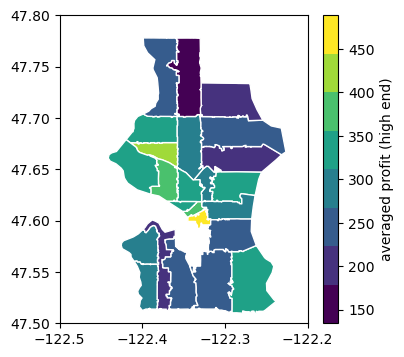

In [22]:
tmp = listings_filtered.groupby('zipcode').agg({'monthly_profit_high_end':'mean', 'id':'count'})
tmp.columns = ['profit_high_end', 'count']
tmp = tmp[tmp['count'] > 5]
fig = zp.plot(tmp['profit_high_end'].to_dict(), label='averaged profit (high end)')

98101 2.666666666666667
98102 3.4682080924855487
98103 0.0
98104 17.1875
98105 0.0
98106 0.0
98107 5.154639175257731
98108 0.0
98109 1.680672268907563
98112 3.4090909090909087
98115 0.0
98116 1.8518518518518516
98117 1.36986301369863
98118 3.0303030303030303
98119 3.614457831325301
98121 3.870967741935484
98122 1.7467248908296942
98125 0.0
98126 0.0
98133 0.0
98136 0.0
98144 5.063291139240507
98177 0.0
98199 0.0


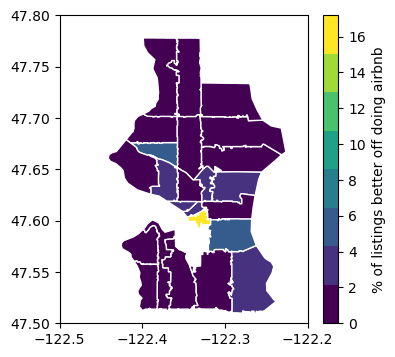

In [23]:
tmp = listings_filtered.groupby('zipcode').agg({'better_airbnb_high_end':'mean', 'id':'count'})
tmp.columns = ['better_airbnb_high_end', 'count']
tmp = tmp[tmp['count'] > 5]
fig = zp.plot((tmp['better_airbnb_high_end']*100).to_dict(), label='% of listings better off doing airbnb')

In [24]:
listings_filtered.shape

(1998, 19)

         better_airbnb_high_end   id
zipcode                             
98101                  0.026667  150
98102                  0.034682  173
98103                  0.000000  202
98104                  0.171875   64
98105                  0.000000  103
98106                  0.000000   27
98107                  0.051546   97
98108                  0.000000   14
98109                  0.016807  119
98112                  0.034091   88
98115                  0.000000   81
98116                  0.018519   54
98117                  0.013699   73
98118                  0.030303   66
98119                  0.036145   83
98121                  0.038710  155
98122                  0.017467  229
98125                  0.000000   27
98126                  0.000000   29
98133                  0.000000   17
98134                  0.000000    2
98136                  0.000000   21
98144                  0.050633   79
98146                  0.000000    2
98177                  0.000000    9
9

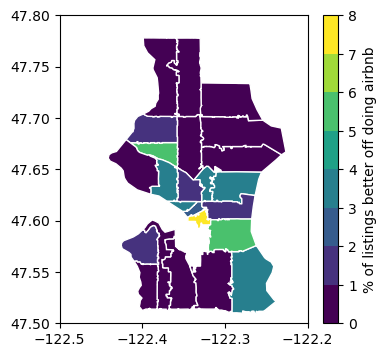

In [25]:
tmp = listings_filtered.groupby('zipcode').agg({'better_airbnb_high_end':'mean', 'id':'count'})
print(tmp)
tmp.columns = ['better_airbnb_high_end', 'count']
tmp = tmp[tmp['count'] > 5]
fig = zp.plot((tmp['better_airbnb_high_end']*100).to_dict(), 
              label='% of listings better off doing airbnb',
              vmin=0, vmax=8)

98101 1.3333333333333335
98102 0.5780346820809248
98103 0.0
98104 4.6875
98105 0.0
98106 0.0
98107 2.0618556701030926
98108 0.0
98109 1.680672268907563
98112 1.1363636363636365
98115 0.0
98116 1.8518518518518516
98117 0.0
98118 0.0
98119 1.2048192771084338
98121 1.2903225806451613
98122 0.0
98125 0.0
98126 0.0
98133 0.0
98136 0.0
98144 1.2658227848101267
98177 0.0
98199 0.0


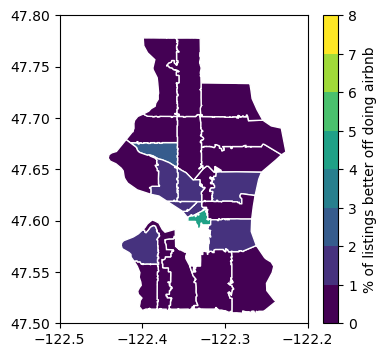

In [26]:
tmp = listings_filtered.groupby('zipcode').agg({'better_airbnb_low_end':'mean', 'id':'count'})
tmp.columns = ['better_airbnb_low_end', 'count']
tmp = tmp[tmp['count'] > 5]
fig = zp.plot((tmp['better_airbnb_low_end']*100).to_dict(), 
              label='% of listings better off doing airbnb',
              vmin=0, vmax=8)

### Well, looks pretty gloomy unless the listings are in downtown area; even that, only ~17% are better off doing airbnb for the higher end, and ~5% for the lower end. Be aware though, I am fairly conservative here; to be fair, I need to take out some portions out of the rent (e.g. tax, vacancy etc).

### last but not least, let's save the file!

In [27]:
listings_filtered.to_csv('listings_filtered.csv', index=False)